In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Activation
import pandas as pd
import os
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")
import json

### 预测整体未来一天的分时段工资

In [3]:
def create_xtest(data,n_predictions,n_next):
    """
    创建测试集
    """
    test_X = []
    for i in range(data.shape[0] - n_predictions - n_next + 1):
        a = data[(i + n_predictions - n_next ):(i +  (2 * n_predictions) - n_next),:]
        test_X.append(a)
    test_X = np.array(test_X,dtype='float64')
    return test_X

In [4]:
def Y_to_seq(Y):
    seq = []
    for i in range(Y.shape[0]):
        seq.append(Y[i,0])
    for i in range(1,Y.shape[1]):
        seq.append(Y[-1,i])
    return np.array(seq)

In [5]:
def create_dataset(data,n_predictions,n_next):
    '''
    对数据进行处理
    '''
    dim = data.shape[1]
    train_X, train_Y = [], []
    for i in range(data.shape[0]-n_predictions-n_next+1):
        a = data[i:(i+n_predictions),:]
        train_X.append(a)
        tempb = data[(i+n_predictions):(i+n_predictions+n_next),:]
        b = []
        for j in range(len(tempb)):
            for k in range(dim):
                b.append(tempb[j,k])
        train_Y.append(b)
    train_X = np.array(train_X,dtype='float64')
    train_Y = np.array(train_Y,dtype='float64')

    return train_X, train_Y
def trainModel(train_X, train_Y):
    '''
    trainX，trainY: 训练LSTM模型所需要的数据
    '''
    model = Sequential()
    model.add(LSTM(
        140,
        input_shape=(train_X.shape[1], train_X.shape[2]),
        return_sequences=True))
    model.add(Dropout(0.3))

    model.add(LSTM(
        140,
        return_sequences=False))
    model.add(Dropout(0.3))

    model.add(Dense(
        train_Y.shape[1]))
    model.add(Activation("relu"))

    model.compile(loss='mse', optimizer='adam')
    model.fit(train_X, train_Y, epochs=200, batch_size=64, verbose=1)

    return model
def reshape_y_hat(y_hat,dim):
    re_y = np.zeros(len(y_hat),dtype='float64')
    length =int(len(y_hat)/dim)
    re_y = re_y.reshape(length,dim)

    for curdim in range(dim):
        for i in range(length):
            re_y[i,curdim] = y_hat[i + curdim*length]

    return  re_y

In [6]:
with open('salary_day_mean.json','r') as f:
    dataset = json.load(f)
dataset = pd.DataFrame(dataset).T
data = dataset.values
data = data.astype('float32')

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data.ravel().reshape(-1,1)).reshape(-1,1)

In [8]:
Xtrain,Ytrain = create_dataset(data,8,4)
Xtest = create_xtest(data,8,4)

In [9]:
model = trainModel(Xtrain,Ytrain)
model.save("./MultiSteup.h5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/200
225/225 [==============================] - 1s 6ms/sample - loss: 0.4034
Epoch 2/200
225/225 [==============================] - 0s 446us/sample - loss: 0.2419
Epoch 3/200
225/225 [==============================] - 0s 405us/sample - loss: 0.1141
Epoch 4/200
225/225 [==============================] - 0s 393us/sample - loss: 0.0930
Epoch 5/200
225/225 [==============================] - 0s 408us/sample - loss: 0.0927
Epoch 6/200
225/225 [==============================] - 0s 404us/sample - loss: 0.0869
Epoch 7/200
225/225 [==============================] - 0s 400us/sample - loss: 0.0772
Epoch 8/200
225/225 [==============================] - 0s 398us/sample - loss: 0.0811
Epoch 9/200
225/225 [==============================] - 0s 396us/sample - loss: 0.0756
Epoch 10/200
225

In [10]:
y_hat = model.predict(Xtest)
Ytrain = scaler.inverse_transform(Ytrain)
Ypre = scaler.inverse_transform(y_hat)
data = scaler.inverse_transform(data)

In [11]:
Y_output = Y_to_seq(Ypre)

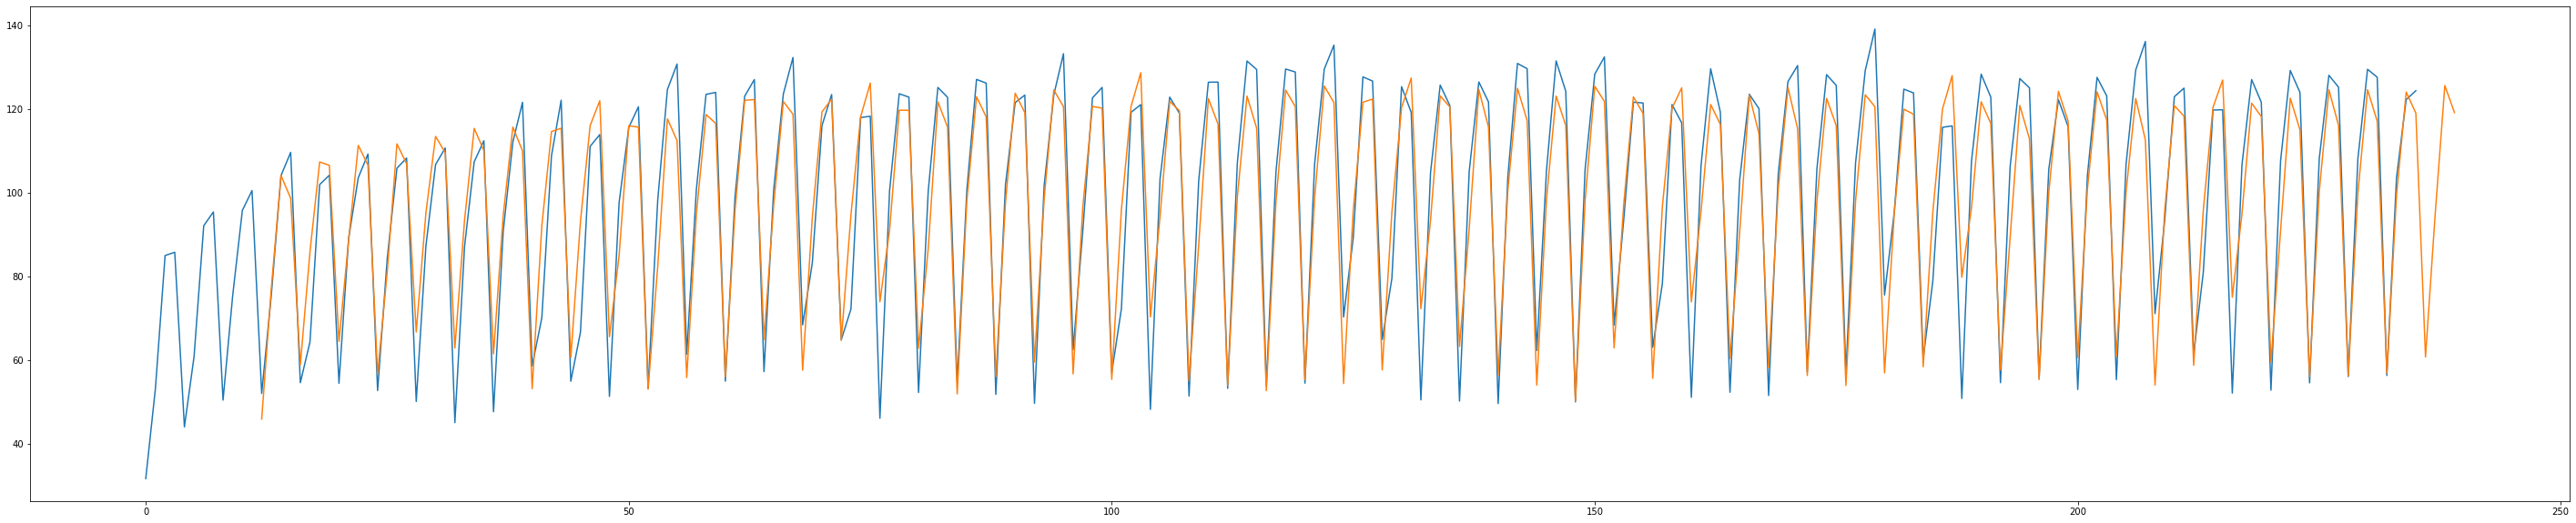

In [12]:
fig, ax = plt.subplots(figsize=(50,10))
x1 = range(data.shape[0])
x2 = range(12,Y_output.shape[0]+12)
plt.plot(x1,data)
plt.plot(x2,Y_output)
plt.show()

In [26]:
Y_output[-4:]
salary = {
    'early_morning' : float(Y_output[-4:][0]),
    'morning' : float(Y_output[-4:][1]),
    'afternoon' : float(Y_output[-4:][2]),
    'night' : float(Y_output[-4:][3])
}

In [27]:
with open('salary_predict.json','w') as f:
    json.dump(salary,f)

In [23]:
salary

{'early_morning': 60.855923,
 'morning': 94.95052,
 'afternoon': 125.71953,
 'night': 119.254036}